In [6]:
pip install datasets transformers evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re

df = pd.read_csv("framing_emotion_output.csv")

def label_weak_misinfo(text):
    keywords = ['miracle', 'cure', 'instantly', 'proven', 'shocking', 'ancient secret', 'banned', 'no side effects']
    text = text.lower()
    if any(kw in text for kw in keywords):
        return "misinfo"
    elif "study" in text or "researchers" in text or "trial" in text:
        return "accurate"
    else:
        return "neutral"

df['weak_misinfo_label'] = df['clean_text'].apply(label_weak_misinfo)
df.to_csv("labeled_misinfo_data.csv", index=False)
df['weak_misinfo_label'].value_counts()


,count
weak_misinfo_label,
neutral,2023
accurate,1026
misinfo,561


In [7]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [8]:
#LOAD AND PREPROCESS CSV DATA
file_path = "framing_emotion_output.csv"  # Change to your CSV file path
df = pd.read_csv(file_path)

# Calculate dominant emotion
emotion_columns = ["emotion_anger", "emotion_joy", "emotion_optimism", "emotion_sadness"]
df["label"] = df[emotion_columns].idxmax(axis=1).str.replace("emotion_", "")

# Keep only relevant columns
df = df[["text", "label"]].dropna()

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"]
)

train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

In [9]:
#TOKENIZE
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2888 [00:00<?, ? examples/s]

Map:   0%|          | 0/722 [00:00<?, ? examples/s]

In [10]:
#LOAD MODEL
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=len(le.classes_))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
#METRIC
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy_metric.compute(predictions=predictions.numpy(), references=labels)

In [12]:
#TRAINING ARGS
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=20,
    save_steps=500,  # Save checkpoint every 500 steps
    warmup_steps=100
)

In [13]:
#TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-13-6f05ca05a46a>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
#TRAIN
trainer.train()

#SAVE MODEL
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aravindmanoj08 (aravindmanoj08-mahe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
20,1.398200
40,1.198900
60,0.959800
80,0.928700
100,0.810900
120,0.680900
140,0.650600
160,0.579600
180,0.636800
200,0.528300


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json',
 './final_model/tokenizer.json')

In [15]:
#Save label encoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Training completed and model saved locally.")

Training completed and model saved locally.



Evaluating on test set...
Test Accuracy: 0.8629

Classification Report:
              precision    recall  f1-score   support

       anger     0.6111    0.6875    0.6471        16
         joy     0.8000    0.7784    0.7890       185
    optimism     0.6410    0.5952    0.6173        42
     sadness     0.9134    0.9248    0.9191       479

    accuracy                         0.8629       722
   macro avg     0.7414    0.7465    0.7431       722
weighted avg     0.8618    0.8629    0.8622       722



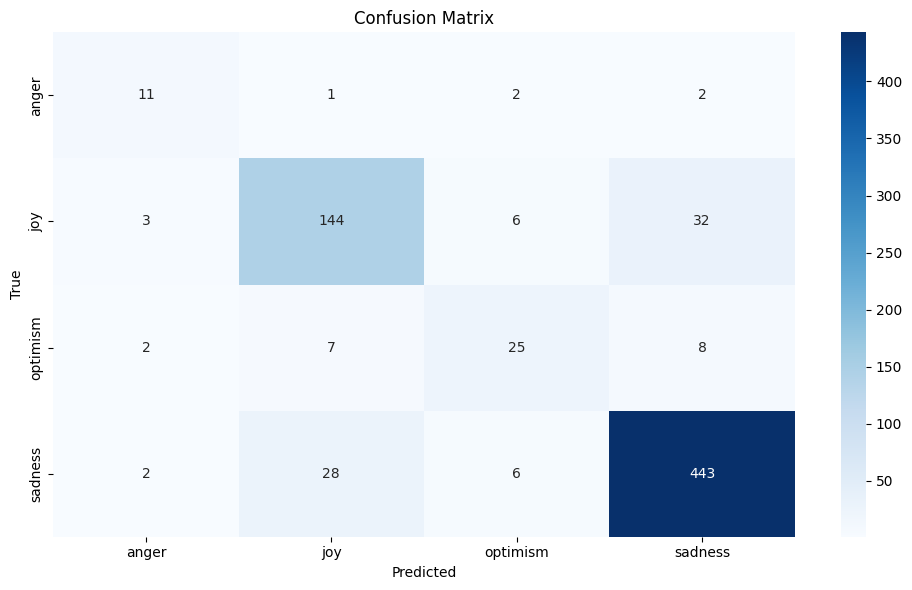

In [16]:
from sklearn.metrics import classification_report

print("\nEvaluating on test set...")

# Evaluate in batches
batch_size = 32  # Adjust as needed based on GPU memory
num_batches = len(test_texts) // batch_size + (len(test_texts) % batch_size != 0)
all_preds = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(test_texts))
    batch_texts = test_texts[start_idx:end_idx]

    # Tokenize and move the current batch to the device
    inputs = tokenizer(list(batch_texts), return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Move predictions to CPU
    all_preds.extend(preds)

# Accuracy
acc = accuracy_score(test_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# Precision, Recall, F1 Score
report = classification_report(test_labels, all_preds, target_names=le.classes_, digits=4)
print("\nClassification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(test_labels, all_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [17]:
#Batch Inference Script

def predict_batch(text_list):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    import pickle

    model = AutoModelForSequenceClassification.from_pretrained("./final_model")
    tokenizer = AutoTokenizer.from_pretrained("./final_model")

    with open("label_encoder.pkl", "rb") as f:
        le = pickle.load(f)

    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1)

    decoded_labels = le.inverse_transform(preds.numpy())
    return decoded_labels